In [2]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

Using TensorFlow backend.


# Load the mix

In [3]:
multitracks = mdb.load_multitracks(["Phoenix_ColliersDaughter"])

In [4]:
mix = next(multitracks)

In [5]:
sample_rate, mix_audio = wavfile.read(mix.mix_path)
mix_audio = mix_audio.mean(1)
mix_audio = mix_audio[sample_rate*8:int(-sample_rate*1.5)]

In [6]:
samples_per_period = 256
overlap = int(samples_per_period/2)

In [7]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

Text(0.5, 0, 'Time (s)')

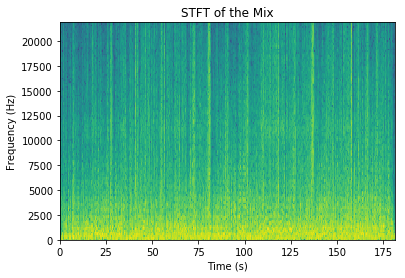

In [8]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
plt.title("STFT of the Mix")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")

# Load the Flute

In [9]:
flutes = mdb.get_files_for_instrument("flute", [mix])

In [10]:
flute = next(flutes)

In [11]:
sample_rate, flute_audio = wavfile.read(flute)
flute_audio = flute_audio.mean(1)
flute_audio = flute_audio[sample_rate*8:int(-sample_rate*1.5)]

In [12]:
freqs, times, s_flute = signal.stft(flute_audio, fs=sample_rate, nfft=samples_per_period, 
                                           noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_flute = s_flute[:-1,:]

Text(0, 0.5, 'Frequency (Hz)')

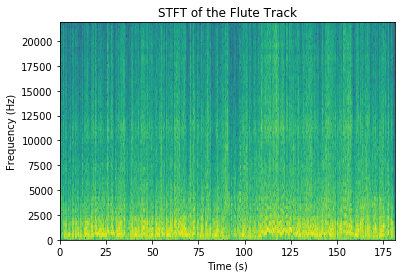

In [13]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_flute)))
plt.title("STFT of the Flute Track")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

## Create a mask for the flute

In [14]:
mask_flute = s_flute / (s_flute + s_mix + 1e-9)

Text(0, 0.5, 'Frequency (Hz)')

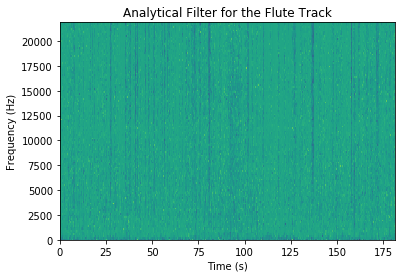

In [15]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(mask_flute)))
plt.title("Analytical Filter for the Flute Track")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [16]:
num_test  = int((sample_rate * 10)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

60694 1722


In [17]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(60694, 128, 2)

In [18]:
flute_train = mask_flute.T[:num_train,:,np.newaxis]
flute_train = np.concatenate((flute_train.real, flute_train.imag), axis=-1)
flute_train.shape

(60694, 128, 2)

In [19]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(1722, 128, 2)

In [20]:
flute_test = mask_flute.T[-num_test:,:,np.newaxis]
flute_test = np.concatenate((flute_test.real, flute_test.imag), axis=-1)
flute_test.shape

(1722, 128, 2)

In [47]:
model = Sequential()

model.add(Dense(128, input_shape=mix_train.shape[1:], activation="relu", name="Dense_1"))

model.add(Dense(2, activation="relu"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 128, 128)          384       
_________________________________________________________________
dense_1 (Dense)              (None, 128, 2)            258       
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'])

In [49]:
history = model.fit(mix_train, flute_train, batch_size=200, epochs=10)

Epoch 1/10
60694/60694 [==============================] - 20s 327us/step - loss: 4.6754 - acc: 0.8095
Epoch 2/10
60694/60694 [==============================] - 18s 295us/step - loss: 4.2019 - acc: 0.8108
Epoch 3/10
60694/60694 [==============================] - 18s 301us/step - loss: 4.2019 - acc: 0.8108
Epoch 4/10
60694/60694 [==============================] - 15s 255us/step - loss: 4.2019 - acc: 0.8108
Epoch 5/10
60694/60694 [==============================] - 15s 244us/step - loss: 4.2019 - acc: 0.8108
Epoch 6/10
60694/60694 [==============================] - 14s 234us/step - loss: 4.2019 - acc: 0.8108
Epoch 7/10
60694/60694 [==============================] - 14s 232us/step - loss: 4.2019 - acc: 0.8108
Epoch 8/10
60694/60694 [==============================] - 16s 267us/step - loss: 4.2019 - acc: 0.8108
Epoch 9/10
60694/60694 [==============================] - 17s 280us/step - loss: 4.2019 - acc: 0.8108
Epoch 10/10
60694/60694 [==============================] - 16s 258us/step - loss: 

In [50]:
results = model.evaluate(mix_test, flute_test)

print(model.metrics_names)
print(results)

1722/1722 [==============================] - 0s 226us/step
['loss', 'acc']
[0.580590262230265, 0.8181121153421657]


# Results

In [25]:
mask_prediction = model.predict(mix_test)
mask_prediction.shape

(1722, 128, 2)

In [26]:
mask_prediction = np.sqrt((mask_prediction**2).sum(-1)).T

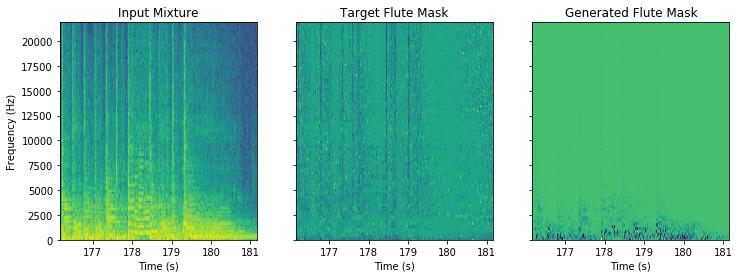

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target Flute Mask")
ax3.set_title("Generated Flute Mask")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(mask_flute[:,-num_test:])))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(mask_prediction))

In [28]:
target = s_mix[:,-num_test:] * mask_flute[:,-num_test:]

In [29]:
prediction = s_mix[:,-num_test:] * mask_prediction

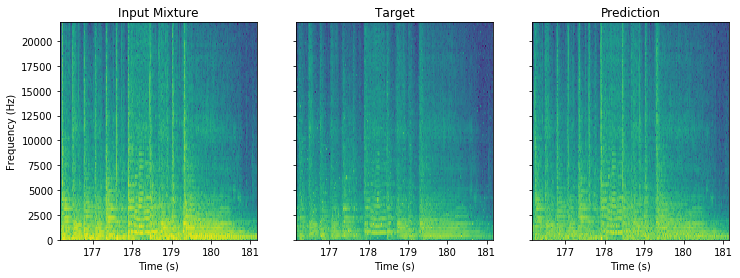

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [31]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)

In [32]:
wavfile.write("shallow_dense_model_flute_prediction.wav", sample_rate, predicted_audio.astype(np.int16))

In [33]:
_, target_audio = signal.istft(target, fs=sample_rate)

In [34]:
wavfile.write("shallow_dense_model_flute_target.wav", sample_rate, target_audio.astype(np.int16))

In [35]:
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

In [36]:
wavfile.write("shallow_dense_model_original.wav", sample_rate, mix_audio.astype(np.int16))